[*********************100%%**********************]  1 of 1 completed


<ipython-input-30-0f07cde26aec>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Signal'][sma_short_window:] = np.where(


Sharpe Ratio: 2.787465281760421


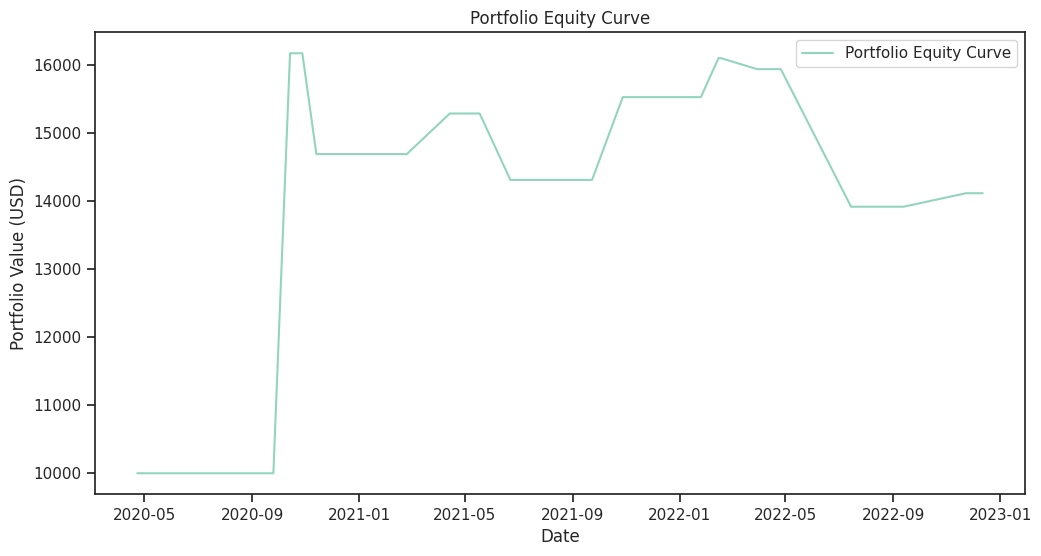

Stat                 SMA_Crossover
-------------------  ---------------
Start                2020-01-01
End                  2021-12-30
Risk-free rate       0.00%

Total Return         92.53%
Daily Sharpe         1.47
Daily Sortino        2.43
CAGR                 38.85%
Max Drawdown         -26.70%
Calmar Ratio         1.45

MTD                  7.80%
3m                   16.97%
6m                   25.66%
YTD                  14.97%
1Y                   14.09%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  38.85%

Daily Sharpe         1.47
Daily Sortino        2.43
Daily Mean (ann.)    35.71%
Daily Vol (ann.)     24.28%
Daily Skew           0.17
Daily Kurt           6.98
Best Day             10.47%
Worst Day            -8.01%

Monthly Sharpe       1.34
Monthly Sortino      3.37
Monthly Mean (ann.)  38.45%
Monthly Vol (ann.)   28.69%
Monthly Skew         0.35
Monthly Kurt         -0.01
Best Month           21.66%
Worst Month          -12.99%


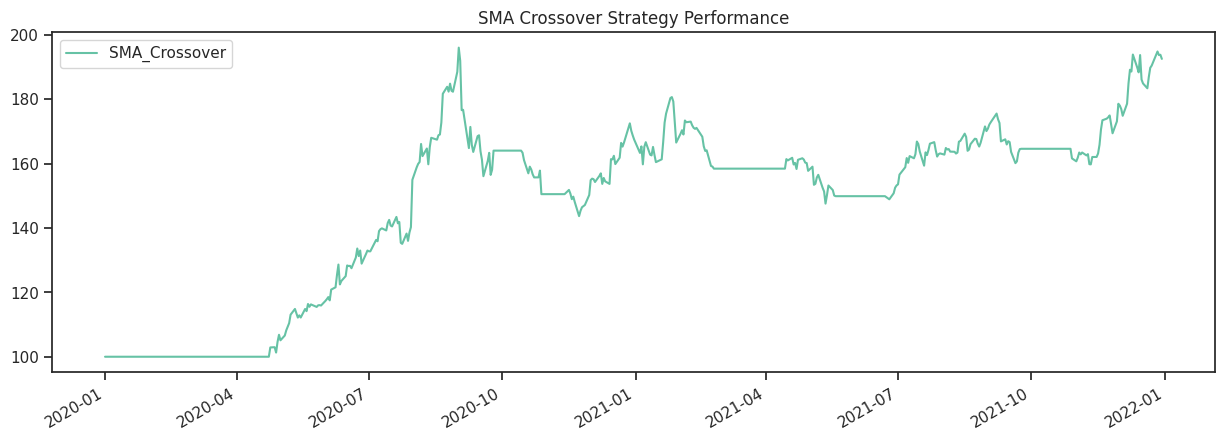

In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt

# Step 1: Data Retrieval
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2022-12-31"
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Step 2: Calculate Simple Moving Averages (SMA)
sma_short_window = 12  # Short-term SMA window
sma_long_window = 50   # Long-term SMA window

stock_data['SMA_Short'] = stock_data['Close'].rolling(window=sma_short_window).mean()
stock_data['SMA_Long'] = stock_data['Close'].rolling(window=sma_long_window).mean()

# Step 3: Generate Trading Signals (SMA Crossover Strategy)
stock_data['Signal'] = 0  # Initialize signal column with zeros
stock_data['Signal'][sma_short_window:] = np.where(
    stock_data['SMA_Short'][sma_short_window:] > stock_data['SMA_Long'][sma_short_window:],
    1, 0
)
stock_data['Signal'] = stock_data['Signal'].diff()  # Generate buy/sell signals

# Step 4: Define Transaction Costs and Slippage
transaction_cost = 0.005  # 0.5% transaction cost per trade
slippage = 0.01  # 1% slippage per trade

# Step 5: Implement Risk Management and Portfolio Optimization
initial_balance = 10000  # Initial portfolio balance in USD
balance = initial_balance
position = 0  # Number of shares held
buy_price = 0

# Lists to track trade information
dates = []
actions = []  # 'Buy' or 'Sell' actions
prices = []
balances = []

for date, row in stock_data.iterrows():
    if row['Signal'] == 1:
        # Buy signal
        if position == 0:
            # Buy if not holding a position
            position = (balance / row['Close']) * (1 - transaction_cost)
            buy_price = row['Close'] * (1 + slippage)
            balance = 0
            dates.append(date)
            actions.append('Buy')
            prices.append(buy_price)
            balances.append(balance)
    elif row['Signal'] == -1:
        # Sell signal
        if position > 0:
            # Sell if holding a position
            balance = position * row['Close'] * (1 - transaction_cost)
            position = 0
            dates.append(date)
            actions.append('Sell')
            prices.append(row['Close'] * (1 - slippage))
            balances.append(balance)

# Calculate portfolio returns
returns = [initial_balance]
for i in range(1, len(dates)):
    returns.append(balances[i - 1] if balances[i - 1] != 0 else returns[i - 1])

# Step 6: Performance Metrics
portfolio_returns = pd.Series(returns, index=dates)
daily_returns = portfolio_returns.pct_change().dropna()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)  # Assuming 252 trading days per year

# Print performance metrics
print("Sharpe Ratio:", sharpe_ratio)

# Step 7: Walk-Forward Testing (e.g., quarterly)
quarterly_dates = pd.date_range(start=start_date, end=end_date, freq='Q')
walk_forward_returns = []
for i in range(1, len(quarterly_dates)):
    start_date = quarterly_dates[i - 1]
    end_date = quarterly_dates[i]
    quarterly_returns = portfolio_returns[start_date:end_date]

    # Check if there are valid returns in the quarter
    if not quarterly_returns.empty:
        cumulative_return = (quarterly_returns / quarterly_returns.iloc[0]).iloc[-1]
        walk_forward_returns.append(cumulative_return)
    else:
        walk_forward_returns.append(1.0)  # No returns, so cumulative return is 1.0

# Step 8: Stress Testing (e.g., market crash)
stress_test_start_date = "2020-02-19"  # Start date of a market crash scenario
stress_test_end_date = "2022-03-23"    # End date of the market crash scenario
stress_test_returns = portfolio_returns[stress_test_start_date:stress_test_end_date]

# Step 9: Visualize Results (e.g., equity curve)
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns.index, portfolio_returns, label='Portfolio Equity Curve', alpha=0.7)
plt.legend()
plt.title('Portfolio Equity Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.show()

# Additional Step 10: Using bt for Backtesting and Visualization (Optional)
# Define the strategy
sma_short_window = 12  # Short-term SMA window
sma_long_window = 50   # Long-term SMA window

# Create a data feed from Yahoo Finance
data = bt.get('AAPL', start='2020-01-01', end='2021-12-31')

# Calculate simple moving averages
sma_short = data.rolling(window=sma_short_window).mean()
sma_long = data.rolling(window=sma_long_window).mean()

# Generate trading signals
signals = sma_short > sma_long

# Define the trading strategy
bt_strategy = bt.Strategy(
    'SMA_Crossover',
    [
        bt.algos.SelectWhere(signals),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ]
)

# Create the backtest
bt_backtest = bt.Backtest(bt_strategy, data)

# Run the backtest
bt_result = bt.run(bt_backtest)

# Plot the performance
bt_result.plot(title='SMA Crossover Strategy Performance')

# Display performance metrics
print(bt_result.display())


[*********************100%%**********************]  1 of 1 completed


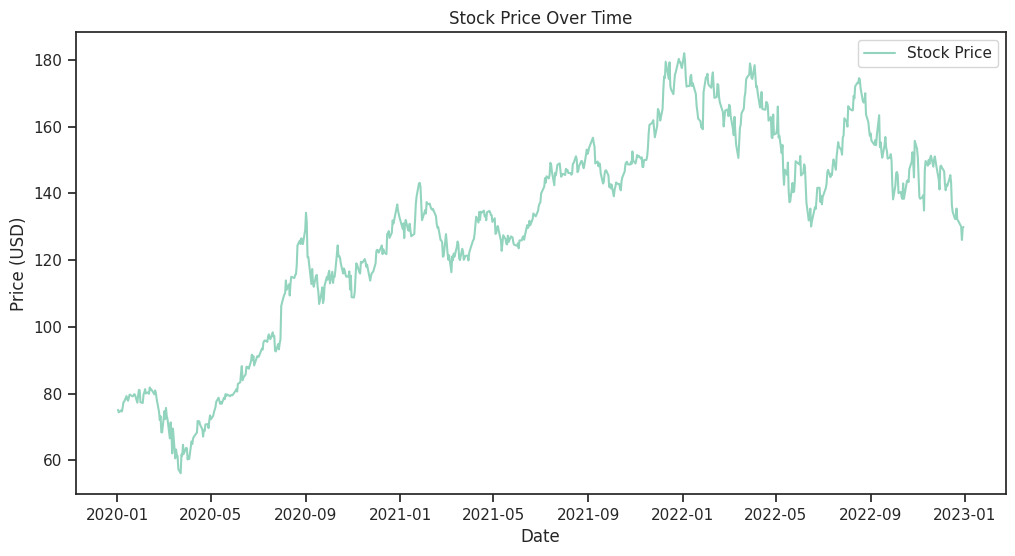

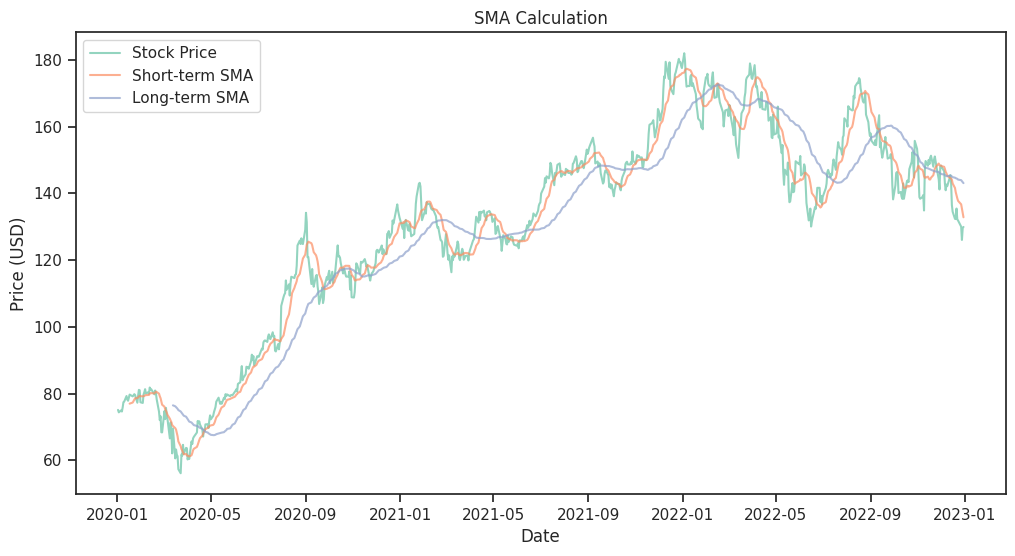

<ipython-input-43-59167afa4af5>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Signal'][sma_short_window:] = np.where(


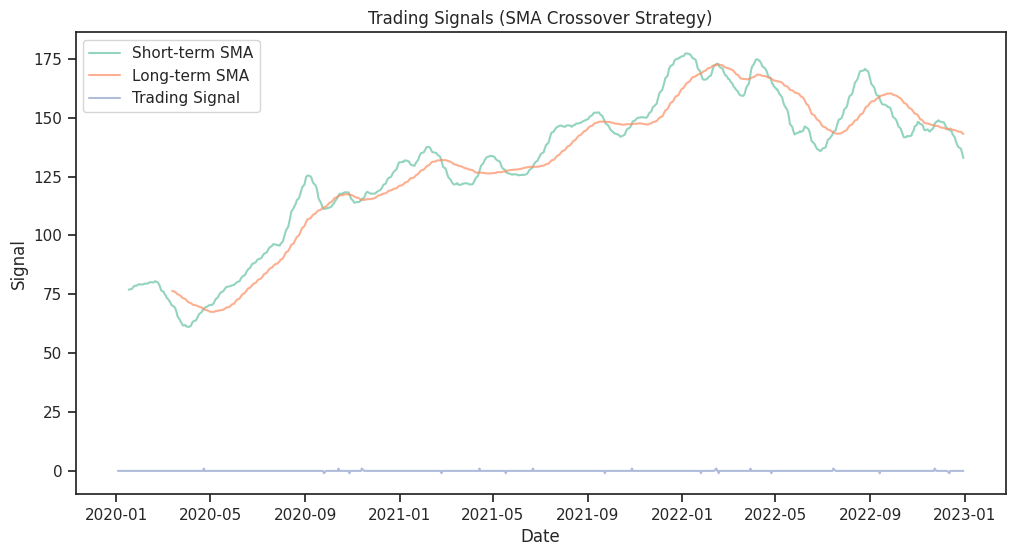

Sharpe Ratio: 2.787465281760421


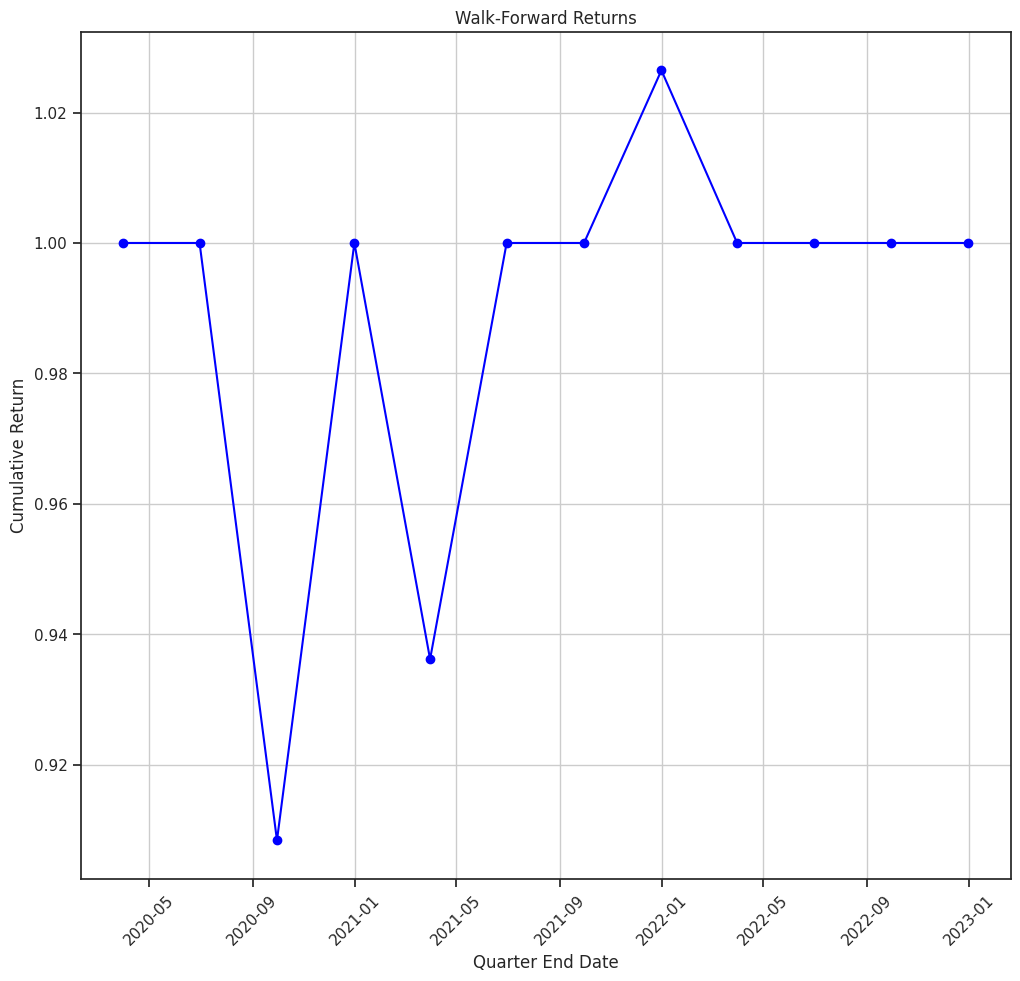

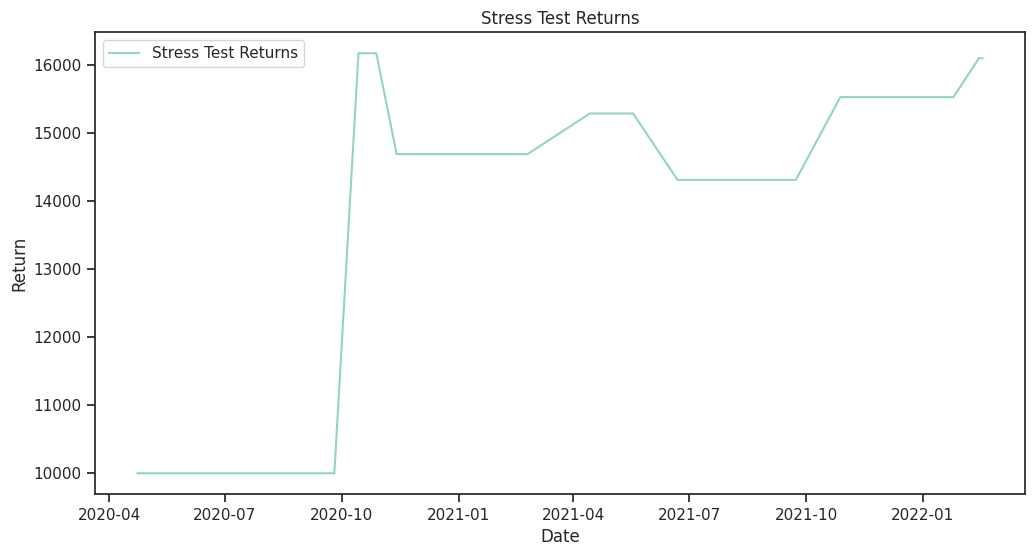

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt

# Step 1: Data Retrieval
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2022-12-31"
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Visualize Data Retrieval
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', alpha=0.7)
plt.legend()
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Step 2: Calculate Simple Moving Averages (SMA)
sma_short_window = 12  # Short-term SMA window
sma_long_window = 50   # Long-term SMA window

stock_data['SMA_Short'] = stock_data['Close'].rolling(window=sma_short_window).mean()
stock_data['SMA_Long'] = stock_data['Close'].rolling(window=sma_long_window).mean()

# Visualize SMA Calculation
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', alpha=0.7)
plt.plot(stock_data.index, stock_data['SMA_Short'], label='Short-term SMA', alpha=0.7)
plt.plot(stock_data.index, stock_data['SMA_Long'], label='Long-term SMA', alpha=0.7)
plt.legend()
plt.title('SMA Calculation')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Step 3: Generate Trading Signals (SMA Crossover Strategy)
stock_data['Signal'] = 0  # Initialize signal column with zeros
stock_data['Signal'][sma_short_window:] = np.where(
    stock_data['SMA_Short'][sma_short_window:] > stock_data['SMA_Long'][sma_short_window:],
    1, 0
)
stock_data['Signal'] = stock_data['Signal'].diff()  # Generate buy/sell signals

# Visualize Trading Signals
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['SMA_Short'], label='Short-term SMA', alpha=0.7)
plt.plot(stock_data.index, stock_data['SMA_Long'], label='Long-term SMA', alpha=0.7)
plt.plot(stock_data.index, stock_data['Signal'], label='Trading Signal', alpha=0.7)
plt.legend()
plt.title('Trading Signals (SMA Crossover Strategy)')
plt.xlabel('Date')
plt.ylabel('Signal')
plt.show()

# Step 4: Define Transaction Costs and Slippage
transaction_cost = 0.005  # 0.5% transaction cost per trade
slippage = 0.01  # 1% slippage per trade

# Step 5: Implement Risk Management and Portfolio Optimization
initial_balance = 10000  # Initial portfolio balance in USD
balance = initial_balance
position = 0  # Number of shares held
buy_price = 0

# Lists to track trade information
dates = []
actions = []  # 'Buy' or 'Sell' actions
prices = []
balances = []

for date, row in stock_data.iterrows():
    if row['Signal'] == 1:
        # Buy signal
        if position == 0:
            # Buy if not holding a position
            position = (balance / row['Close']) * (1 - transaction_cost)
            buy_price = row['Close'] * (1 + slippage)
            balance = 0
            dates.append(date)
            actions.append('Buy')
            prices.append(buy_price)
            balances.append(balance)
    elif row['Signal'] == -1:
        # Sell signal
        if position > 0:
            # Sell if holding a position
            balance = position * row['Close'] * (1 - transaction_cost)
            position = 0
            dates.append(date)
            actions.append('Sell')
            prices.append(row['Close'] * (1 - slippage))
            balances.append(balance)

# Calculate portfolio returns
returns = [initial_balance]
for i in range(1, len(dates)):
    returns.append(balances[i - 1] if balances[i - 1] != 0 else returns[i - 1])

# Step 6: Performance Metrics
portfolio_returns = pd.Series(returns, index=dates)
daily_returns = portfolio_returns.pct_change().dropna()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)  # Assuming 252 trading days per year

# Print performance metrics
print("Sharpe Ratio:", sharpe_ratio)

# Step 7: Walk-Forward Testing (e.g., quarterly)
quarterly_dates = pd.date_range(start=start_date, end=end_date, freq='Q')
walk_forward_returns = []

for i in range(1, len(quarterly_dates)):
    start_date = quarterly_dates[i - 1]
    end_date = quarterly_dates[i]
    quarterly_returns = portfolio_returns[start_date:end_date]

    # Check if there are valid returns in the quarter
    if not quarterly_returns.empty:
        cumulative_return = (quarterly_returns / quarterly_returns.iloc[0]).iloc[-1]
        walk_forward_returns.append(cumulative_return)
    else:
        walk_forward_returns.append(1.0)  # No returns, so cumulative return is 1.0

# Add one more return value to match the length of quarterly_dates
walk_forward_returns.append(1.0)  # Assuming the last quarter has no returns

# Step 8: Visualize Walk-Forward Returns
plt.figure(figsize=(12, 11))
plt.plot(quarterly_dates, walk_forward_returns, marker='o', linestyle='-', color='b')
plt.title('Walk-Forward Returns')
plt.xlabel('Quarter End Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Step 9: Stress Testing (e.g., market crash)
stress_test_start_date = "2020-02-19"  # Start date of a market crash scenario
stress_test_end_date = "2022-03-23"    # End date of the market crash scenario
stress_test_returns = portfolio_returns[stress_test_start_date:stress_test_end_date]

# Visualize Stress Test Returns
plt.figure(figsize=(12, 6))
plt.plot(stress_test_returns.index, stress_test_returns, label='Stress Test Returns', alpha=0.7)
plt.legend()
plt.title('Stress Test Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()
